<a href="https://colab.research.google.com/github/bsb0123-coder/-/blob/main/%EC%8B%9C%EA%B3%84%EC%97%B4_%EA%B8%B0%EC%98%A8_%EB%B3%80%ED%99%94_%EB%B6%84%EC%84%9D_%EB%B0%8F_%EA%B8%B0%ED%9B%84_%EB%B3%80%EC%88%98_%EC%83%81%EA%B4%80%EA%B4%80%EA%B3%84_%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas matplotlib seaborn scikit-learn

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# Install a Korean font if not already available
!apt-get update -qq
!apt-get install fonts-nanum -qq > /dev/null

# Configure matplotlib to use the installed font
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False # This ensures minus signs are displayed correctly

print("Matplotlib has been configured to use NanumGothic font.")

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Matplotlib has been configured to use NanumGothic font.


In [ ]:
import pandas as pd
import numpy as np

# 전처리 이전의 csv파일 불러오기
fp = "/content/drive/MyDrive/2000.01~2025.10 월단위 평균온도, 습도, 강수량, 일사량 자료 (기상청).csv"
df = pd.read_csv(fp, encoding="cp949")

# 칼럼 이름 수정
rename_map = {
    '지점': 'station_id',
    '지점명': 'station_name',
    '일시': 'Date_raw',
    '평균기온(°C)': 'temperature',
    '평균상대습도(%)': 'humidity',
    '월합강수량(00~24h만)(mm)': 'precipitation',
    '합계 일사량(MJ/m2)': 'sunshine'
}
df.rename(columns=rename_map, inplace=True)

# 날짜 포맷 통일
def parse_month(date_str):
    for fmt in ("%Y.%m", "%Y-%m", "%Y.%m.%d", "%Y-%m-%d", "%Y/%m", "%Y/%m/%d"):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except:
            continue
    return pd.to_datetime(date_str, errors='coerce')

df['Date'] = df['Date_raw'].astype(str).apply(parse_month)

# 월 단위로 통일
df['Date'] = df['Date'].dt.to_period('M').dt.to_timestamp()

# year/month 생성
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month

# 필요한 지역만 필터
selected_stations = ["강릉", "서울", "대구", "창원", "제주"]
df = df[df['station_name'].isin(selected_stations)].copy()
df.sort_values(['station_name','Date'], inplace=True)

# 창원의 일사량이 결측된 2000-01 부터 2015-08 까지의 값을 보정
start = pd.to_datetime("2000-01-01")
end   = pd.to_datetime("2015-08-01")

mask_changwon = (
    (df['station_name']=="창원") &
    (df['Date']>=start) &
    (df['Date']<=end) &
    (df['sunshine'].isna())
)

missing_dates = df.loc[mask_changwon, 'Date'].unique()

for d in missing_dates:
    mean_val = df[(df['Date']==d) &
                  (df['station_name']!="창원")]['sunshine'].mean()
    df.loc[(df['Date']==d) &
           (df['station_name']=="창원"), 'sunshine'] = mean_val

# 나머지 결측치 보정
numeric_cols = ['temperature','humidity','precipitation','sunshine']

station_month_mean = df.groupby(['station_name','month'])[numeric_cols].mean()
station_month_mean.columns = [c + "_sm_mean" for c in numeric_cols]
station_month_mean = station_month_mean.reset_index()

df = df.merge(station_month_mean, on=['station_name','month'], how='left')

for col in numeric_cols:
    df[col] = df[col].fillna(df[col + "_sm_mean"])
    df[col] = df[col].fillna(df.groupby("station_name")[col].transform("mean"))
    df[col] = df[col].fillna(df[col].mean())

df.drop(columns=[c for c in df.columns if c.endswith("_sm_mean")], inplace=True)

# 불필요한 컬럼 제거
df.drop(columns=['Date_raw', 'Date'], inplace=True)

# 컬럼 순서 재배열
desired_columns = ['station_id', 'station_name', 'year', 'month', 'temperature', 'humidity', 'precipitation', 'sunshine']
df = df[desired_columns]

# 전처리 이후의 csv파일 저장
df.to_csv("/content/drive/MyDrive/전처리 이후(정리버전).csv", index=False, encoding="utf-8-sig")

display(df.head(1500))

,station_id,station_name,year,month,temperature,humidity,precipitation,sunshine
0,105,강릉,2000,1,0.8,58,66.3,133.70
1,105,강릉,2000,2,0.9,39,3.3,224.60
2,105,강릉,2000,3,8.1,41,15.9,271.70
3,105,강릉,2000,4,12.6,50,37.1,370.51
4,105,강릉,2000,5,17.0,70,47.6,467.54
...,...,...,...,...,...,...,...,...
1495,155,창원,2021,4,14.1,53,86.5,586.64
1496,155,창원,2021,5,17.7,64,147.9,588.66
1497,155,창원,2021,6,21.8,74,140.6,598.20
1498,155,창원,2021,7,26.5,77,521.2,598.42


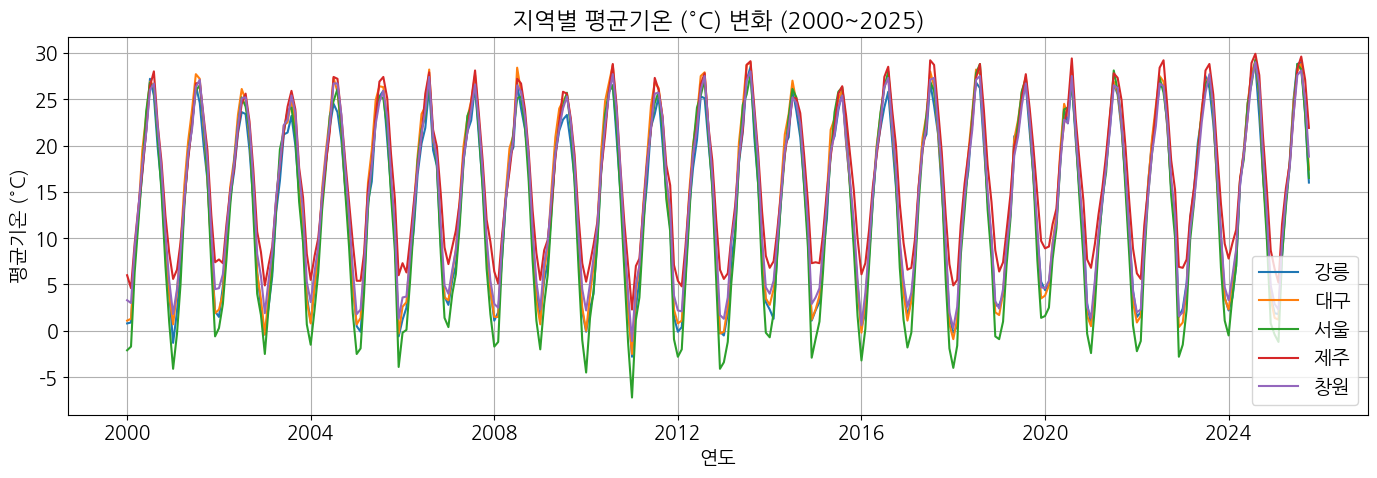

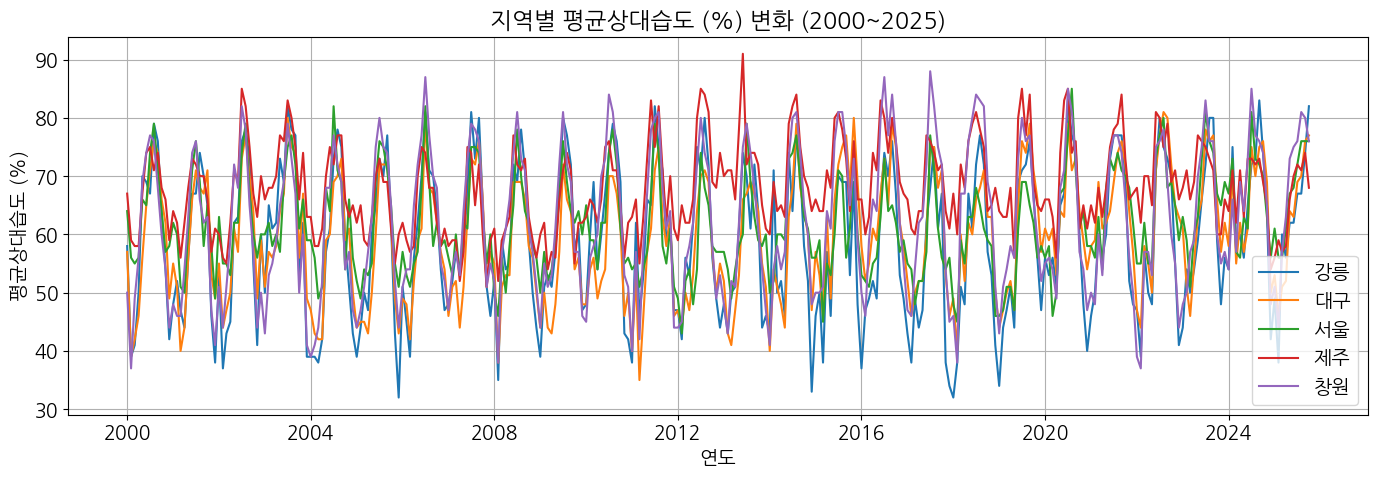

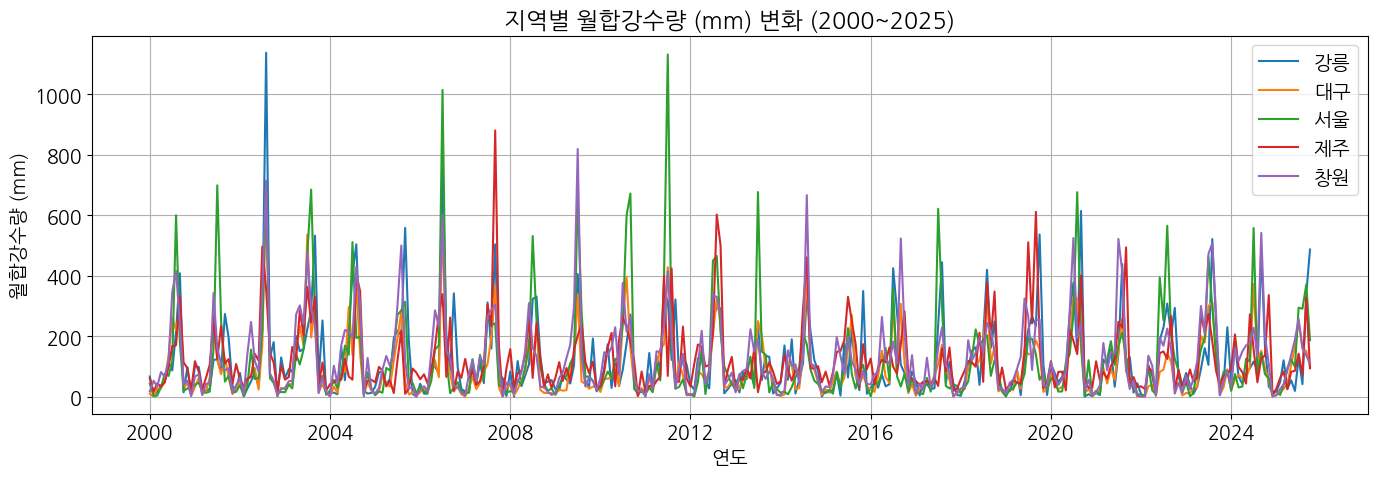

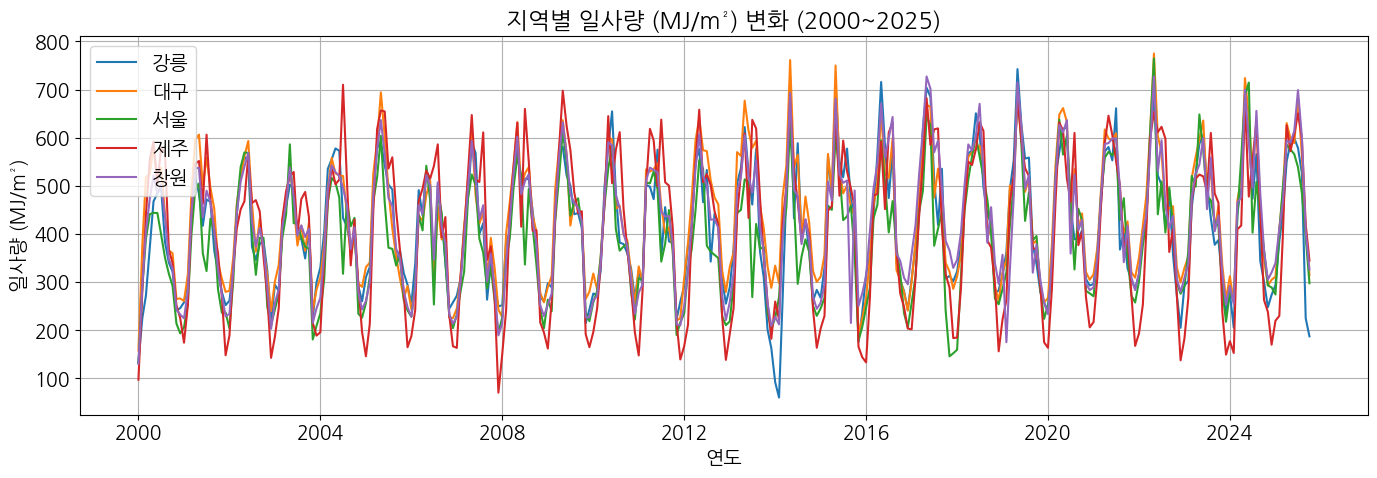

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 전처리 이후 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/전처리 이후.csv", encoding="utf-8-sig")

# 날짜를 pandas datetime으로 변환
df["Date"] = pd.to_datetime(df["Date"])

# 비교할 기후 변수들
variables = {
    "temperature": "평균기온 (°C)",
    "humidity": "평균상대습도 (%)",
    "precipitation": "월합강수량 (mm)",
    "sunshine": "일사량 (MJ/m²)"
}

# 지역 목록
stations = df["station_name"].unique()

#글자 크기 14p로 바꾸기
plt.rcParams.update({'font.size': 14})

# 그래프 출력
for var, label in variables.items():
    plt.figure(figsize=(14, 5))

    for st in stations:
        sub = df[df["station_name"] == st]
        plt.plot(sub["Date"], sub[var], label=st)

    plt.title(f"지역별 {label} 변화 (2000~2025)")
    plt.xlabel("연도")
    plt.ylabel(label)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

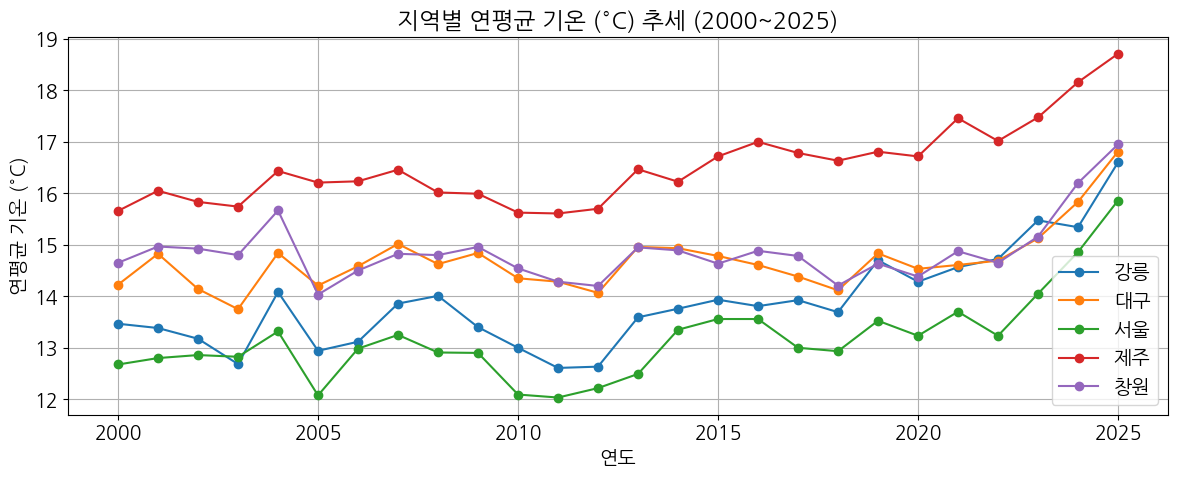

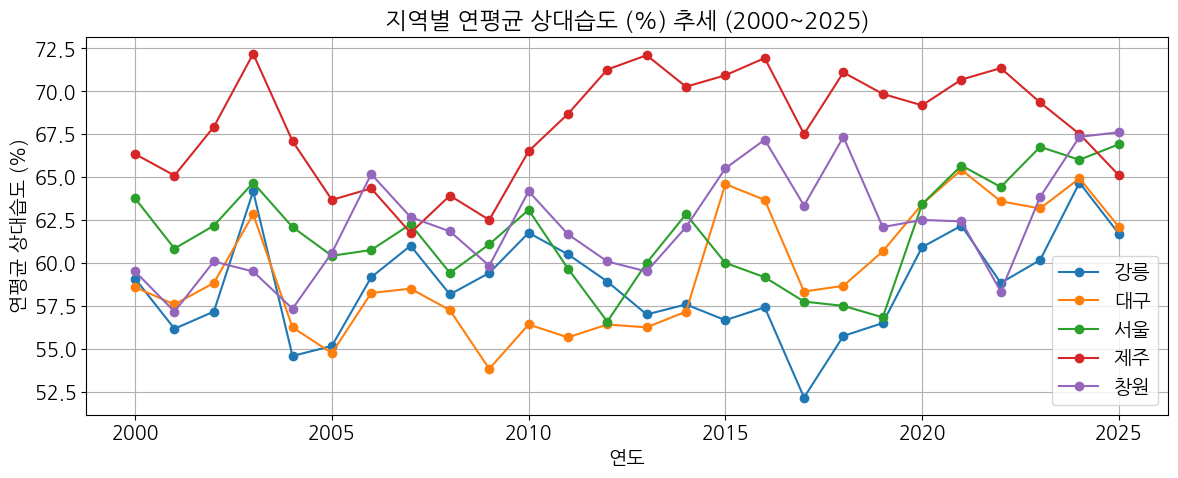

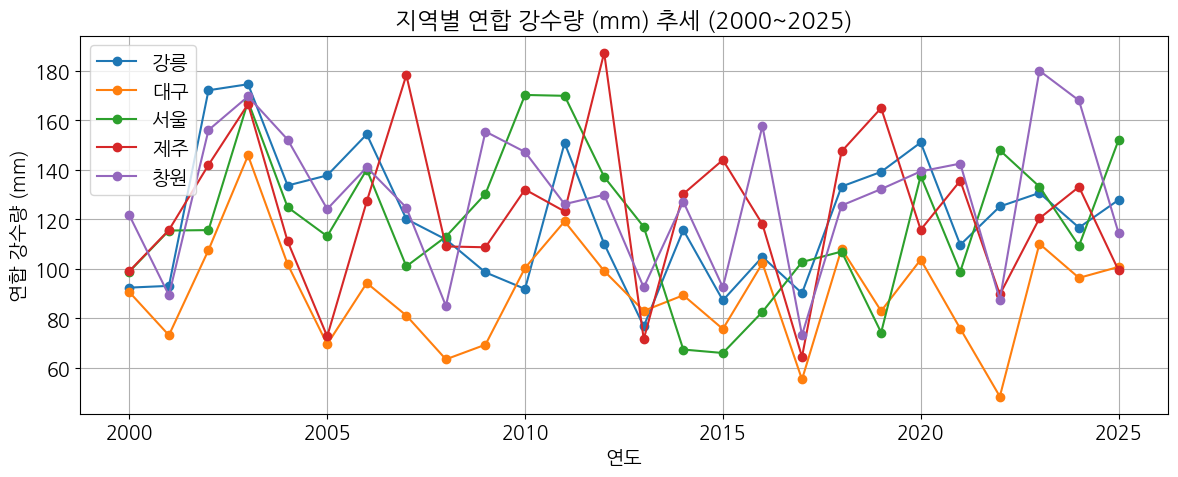

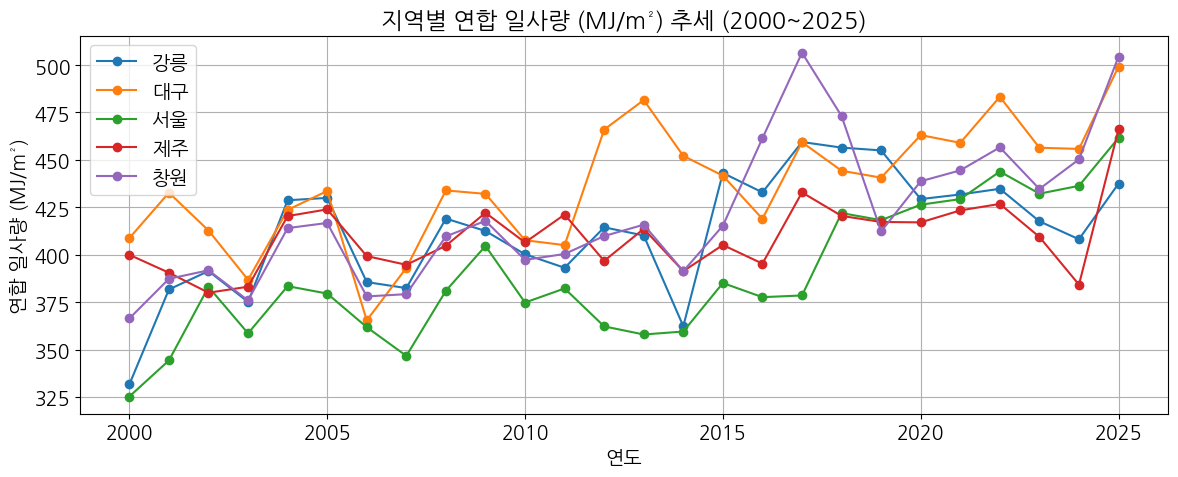

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/전처리 이후.csv", encoding="utf-8-sig")
df["Date"] = pd.to_datetime(df["Date"])
df["year"] = df["Date"].dt.year

# 분석 대상 변수
variables = {
    "temperature": "연평균 기온 (°C)",
    "humidity": "연평균 상대습도 (%)",
    "precipitation": "연합 강수량 (mm)",
    "sunshine": "연합 일사량 (MJ/m²)"
}

stations = df["station_name"].unique()

#글자 크기 14p로 바꾸기
plt.rcParams.update({'font.size': 14})

# 지역별로 연도별 평균 계산 후 그래프 생성
for var, label in variables.items():
    plt.figure(figsize=(12, 5))

    for st in stations:
        sub = df[df["station_name"] == st]
        yearly = sub.groupby("year")[var].mean()

        plt.plot(yearly.index, yearly.values, marker='o', label=st)

    plt.title(f"지역별 {label} 추세 (2000~2025)")
    plt.xlabel("연도")
    plt.ylabel(label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


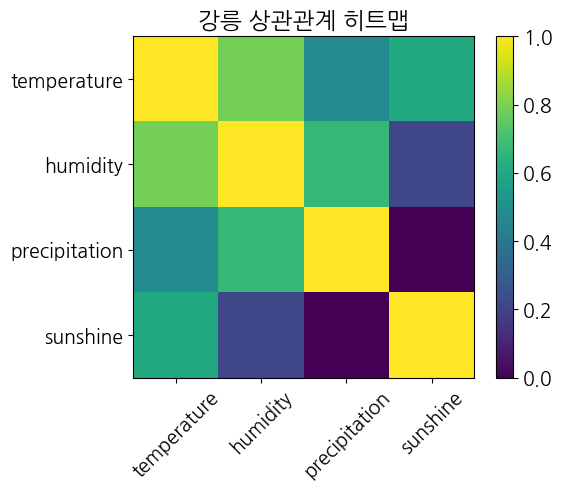


===== 강릉 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.789205       0.481968  0.609101
humidity          0.789205  1.000000       0.665325  0.213538
precipitation     0.481968  0.665325       1.000000 -0.010428
sunshine          0.609101  0.213538      -0.010428  1.000000


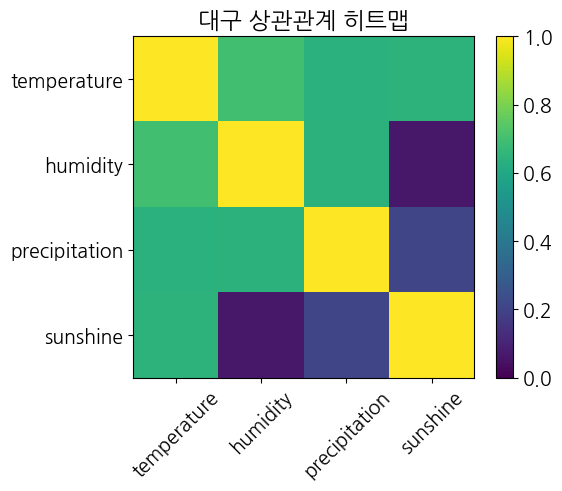


===== 대구 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.696912       0.640517  0.645390
humidity          0.696912  1.000000       0.641906  0.063927
precipitation     0.640517  0.641906       1.000000  0.209812
sunshine          0.645390  0.063927       0.209812  1.000000


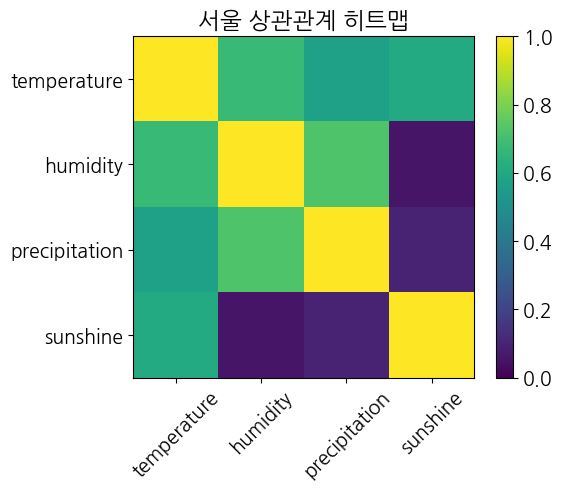


===== 서울 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.678611       0.574158  0.613098
humidity          0.678611  1.000000       0.725390  0.057377
precipitation     0.574158  0.725390       1.000000  0.096184
sunshine          0.613098  0.057377       0.096184  1.000000


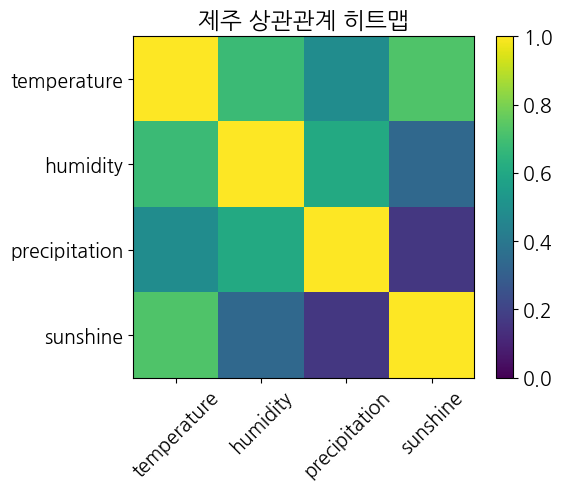


===== 제주 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.680902       0.487936  0.725241
humidity          0.680902  1.000000       0.609305  0.338870
precipitation     0.487936  0.609305       1.000000  0.162760
sunshine          0.725241  0.338870       0.162760  1.000000


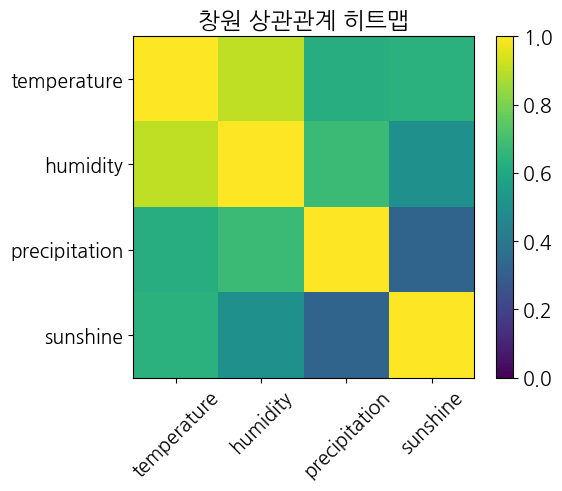


===== 창원 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.904520       0.623627  0.636741
humidity          0.904520  1.000000       0.680518  0.502233
precipitation     0.623627  0.680518       1.000000  0.321569
sunshine          0.636741  0.502233       0.321569  1.000000


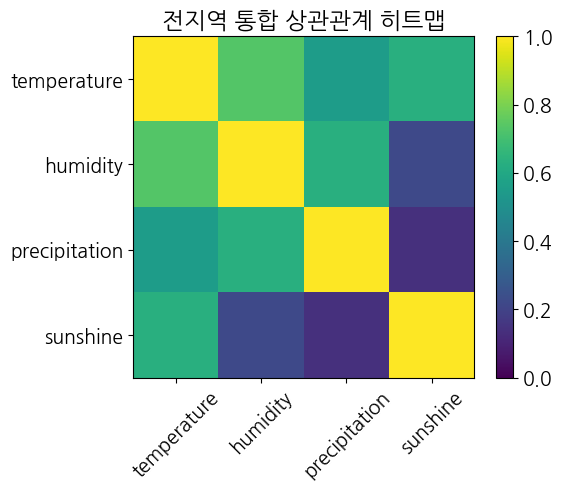


===== 전지역 통합 상관계수 =====
               temperature  humidity  precipitation  sunshine
temperature       1.000000  0.734166       0.551239  0.630722
humidity          0.734166  1.000000       0.629922  0.219505
precipitation     0.551239  0.629922       1.000000  0.137289
sunshine          0.630722  0.219505       0.137289  1.000000


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 폰트 설정 (한글 안 깨지게)
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기
df = pd.read_csv("/content/drive/MyDrive/전처리 이후.csv", encoding="utf-8-sig")

# 분석 변수
features = ["temperature", "humidity", "precipitation", "sunshine"]

# 지역 목록 가져오기
stations = df["station_name"].unique()

# 지역별 상관관계 계산 및 히트맵 출력
for st in stations:
    sub = df[df["station_name"] == st]

    corr = sub[features].corr()

    plt.figure(figsize=(6,5))
    plt.imshow(corr,interpolation='nearest', vmin=0, vmax=1)   # matplotlib 표현
    plt.title(f"{st} 상관관계 히트맵")
    plt.xticks(range(len(features)), features, rotation=45)
    plt.yticks(range(len(features)), features)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    print(f"\n===== {st} 상관계수 =====")
    print(corr)

# 전체 데이터 통합 히트맵
corr_overall = df[features].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr_overall, interpolation='nearest', vmin=0, vmax=1)
plt.title("전지역 통합 상관관계 히트맵")
plt.xticks(range(len(features)), features, rotation=45)
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.tight_layout()
plt.show()

print(f"\n===== 전지역 통합 상관계수 =====")
print(corr_overall)


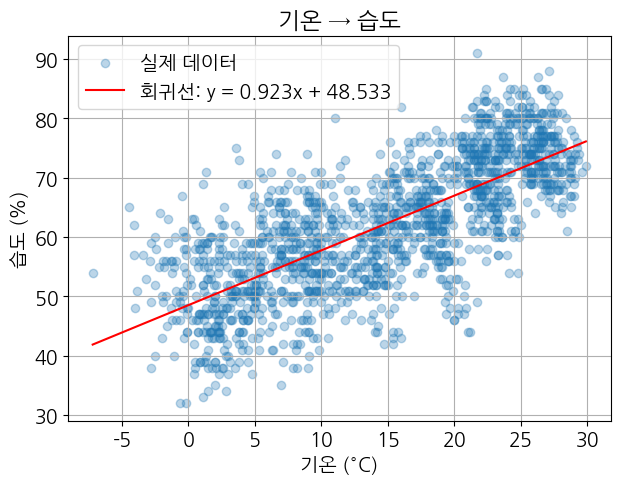

회귀식:  습도 (%) = 0.9230 × 기온 (°C) + 48.5329



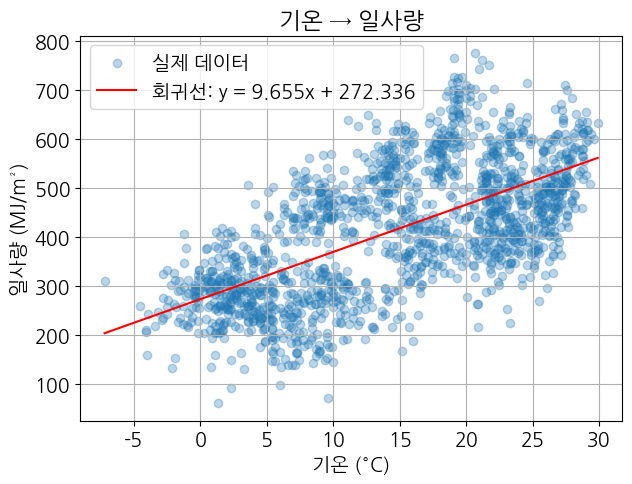

회귀식:  일사량 (MJ/m²) = 9.6546 × 기온 (°C) + 272.3361



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 전처리 이후 CSV 불러오기
df = pd.read_csv("/content/drive/MyDrive/전처리 이후.csv", encoding="utf-8-sig")

# 전체 데이터 사용
df_all = df.copy()

# 독립변수
x_temp = df_all['temperature'] # Changed to x_temp to be specific

def run_regression(x, y, xlabel, ylabel, title):
    # 회귀 계수 구하기
    coef = np.polyfit(x, y, 1)
    slope, intercept = coef

    # 회귀선 생성용 X
    x_line = np.linspace(min(x), max(x), 100)
    y_line = slope * x_line + intercept

    # 시각화
    plt.figure(figsize=(7,5))
    plt.scatter(x, y, alpha=0.3, label="실제 데이터")
    plt.plot(x_line, y_line, color="red", label=f"회귀선: y = {slope:.3f}x + {intercept:.3f}")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"회귀식:  {ylabel} = {slope:.4f} × {xlabel} + {intercept:.4f}")
    print()

y_hum = df_all['humidity']

run_regression(
    x_temp, y_hum,
    xlabel="기온 (°C)",
    ylabel="습도 (%)",
    title="기온 → 습도"
)

y_sun = df_all['sunshine']

run_regression(
    x_temp, y_sun,
    xlabel="기온 (°C)",
    ylabel="일사량 (MJ/m²)",
    title="기온 → 일사량"
)



In [ ]:
# 기온 → 습도
slope_th = 0.9230
intercept_th = 48.5329

# 기온 → 일사량
slope_ts = 9.6546
intercept_ts = 272.3361


# 예측해보고 싶은 값
test_temp = 25 # 예: 기온 25℃

# 예측값 계산
pred_humidity = slope_th * test_temp + intercept_th
pred_sunshine = slope_ts * test_temp + intercept_ts

print("기온 25℃ → 예상 습도:", round(pred_humidity, 2), "%")
print("기온 25℃ → 예상 일사량:", round(pred_sunshine, 2), "MJ/m²")


기온 25℃ → 예상 습도: 71.61 %
기온 25℃ → 예상 일사량: 513.7 MJ/m²
